In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [2]:
quantization_factor = 5

In [3]:
def get_dominant_color(image: np.array):
  # Ensure the image is 3D array
  if len(image.shape) != 3:
    raise ValueError("The image should be a 3D array")

  # Use L*a*b color space to get the dominant color
  cie_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

  # Quantize the colors
  cie_lab = cie_lab // quantization_factor * quantization_factor

  # Get the most common color
  colors, counts = np.unique(cie_lab.reshape(-1, cie_lab.shape[2]), axis=0, return_counts=True)
  most_common_color = colors[np.argmax(counts)]

  return most_common_color

In [4]:
def slice_image(image: np.array, block_size: int = 10):
  # Ensure the image is 3D array
  if len(image.shape) != 3:
    raise ValueError("The image should be a 3D array")

  result = []

  # Slice the image into multiple block_size * block_size pixel blocks
  for i in range(0, image.shape[0], block_size):
    for j in range(0, image.shape[1], block_size):
      # Check if indices are within image size
      end_row = i + block_size
      end_col = j + block_size
      if i + block_size > image.shape[0]:
        end_row = image.shape[0]
      if j + block_size > image.shape[1]:
        end_col = image.shape[1]

      # Get the block
      block = image[i:end_row, j:end_col]
      result.append(get_dominant_color(block))

  return result

In [5]:
def load_image(image_path):
    image = cv2.imread(image_path)
    return image

In [6]:
image_name = "./src/04wooded.jpg"
output_name = image_name.split(".")[-2] + "_output.png"
image = load_image(image_name)
labs = slice_image(image, 10)

In [7]:
lab_array = np.array(labs)
print(lab_array.shape)

# Get the most common color
colors, counts = np.unique(lab_array, axis=0, return_counts=True)

# 10 most common colors with their counts
most_common_colors = colors[np.argsort(counts)[::-1]][:10]
most_common_colors_counts = counts[np.argsort(counts)[::-1]][:10]


(8500, 3)


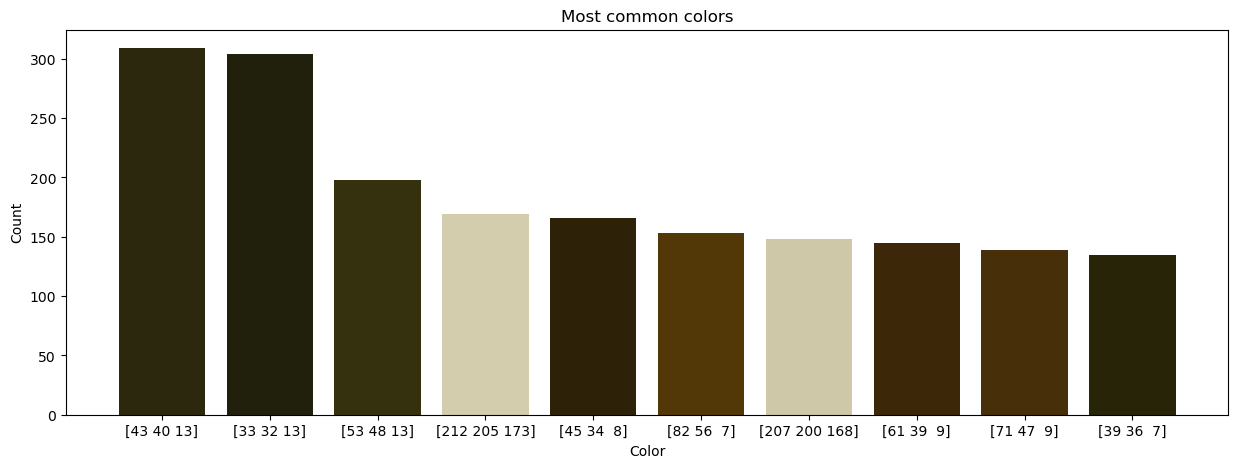

In [8]:
# Change the most common colors to RGB
most_common_colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_LAB2RGB)[0][0] for color in most_common_colors]

# Plot histogram of the most common colors

plt.figure(figsize=(15, 5))
plt.bar(range(10), most_common_colors_counts, color=[(c[0] / 255, c[1] / 255, c[2] / 255) for c in most_common_colors_rgb])
plt.xticks(range(10), [f"{most_common_colors_rgb[i]}" for i in range(10)])
plt.xlabel("Color")
plt.ylabel("Count")
plt.title("Most common colors")
plt.savefig(f".{output_name}")
plt.show()

# Save to image of the same name

In [9]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os,sys
import numpy as np
import cv2
sys.path.append(os.getcwd())
from colors.standout import get_n_standing_out_color,create_dominant_image_graph

def create_overlay_graph_UI(image,colors):
    bgr_image = cv2.cvtColor(np.array(image),cv2.COLOR_BGR2RGB)
    
    Image.fromarray(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)).show()
    cube_size = 30
    separation = (1/3 * cube_size)
    x_start = int(bgr_image.shape[1] - cube_size * len(colors) - 1/3 * (len(colors) - 1) - 50)
    y_start = int(bgr_image.shape[0] - cube_size - 50 )

    for c in colors:
        cube = np.full((cube_size,cube_size,3),c,dtype = np.uint8)
        # print(type(x_start))
        y_start = int(y_start)
        x_start = int(x_start)
        bgr_image[y_start:y_start+cube_size, x_start:x_start+cube_size] = cube
        x_start += cube_size + separation

    result_image_pil = Image.fromarray(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))
    result_image_pil.show()
    return bgr_image

def open_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        image = Image.open(file_path)
        width, height = image.size
        max_width = 720
        max_height = 480
        if width > max_width or height > max_height:
            ratio = min(max_width / width, max_height / height)
            new_width = int(width * ratio)
            new_height = int(height * ratio)
            image = image.resize((new_width, new_height))

        color_list = get_n_standing_out_color(file_path)
        # create_dominant_image_graph(color_list).show()
        overlay_image = create_overlay_graph_UI(image,color_list)
        # photo_image = ImageTk.PhotoImage(overlay_image)
        # img_label.configure(image=photo_image)
        # img_label.image = photo_image
            
root = tk.Tk()
root.title("color scheme generator")
root.geometry("720x480")
txt = tk.Label(root,text="please open the image to generate color scheme.",font=("Times New Roman",24))
open_button = tk.Button(root, text="Open Image", command=open_image,font=("Times New Roman",24))
txt.pack()
open_button.pack()
img_label = tk.Label(root)
img_label.pack()
root.mainloop()